## Exploring our Dart Throws Dataset

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

from skimage.feature import hog     
from skimage import exposure

In [2]:
HOME_DIR = os.environ['HOME']
ROOT_DIR = HOME_DIR + '/shoot_your_shot'
IMG_DIR = ROOT_DIR + '/bg'
CROP_DIR = ROOT_DIR + '/crops'

In [3]:
raw_imgs = glob(IMG_DIR + '/*_raw.png')
blk_imgs = glob(IMG_DIR + '/*_blk.png')
crop_imgs = glob(CROP_DIR + '/*/*.png')

In [4]:
def get_data(img_pth):
    # parse the filename for keypoint and bullseye coords
    im = cv2.imread(img_pth)
    if isinstance(im, np.ndarray):
        w, h = im.shape[:2]
        pth = os.path.splitext(img_pth.split('/')[-1])[0]
        *_, theta, radius, c1, c2, R = pth.split('_')[1:]
        theta, radius = tuple(map(float, (theta, radius)))
        c1, c2, R = [int(float(val)) for val in [c1, c2, R]]
        rad = radius * R
        abs_wrt_bullseye = tuple(map(int, rad * np.array([np.cos(theta), np.sin(theta)]) + np.array([c1, c2])))
        return img_pth, theta, radius, abs_wrt_bullseye, (w, h), R
    else:
        return None

In [5]:
unlbl_imgs = glob(CROP_DIR + '/*.png')
p_lst = sorted(unlbl_imgs)
point_lst = []
for idx in range(len(p_lst)):
    data = get_data(p_lst[idx])
    if data is not None:
        point_lst.append(data)
    else:
        #print(p_lst[idx], ' is corrupted... deleting.')
        os.remove(p_lst[idx])

In [6]:
df = pd.DataFrame(point_lst, columns=['path', 'theta', 'radius', 'absolute', 'crop_size', 'DB_radius'])
df[['x', 'y']] = pd.DataFrame(df['absolute'].tolist(), index=df.index)
df = df.drop('absolute', axis=1)
df.head()

,path,theta,radius,crop_size,DB_radius,x,y
0,/home/area51/shoot_your_shot/crops/15760840195...,0.98,0.55,"(96, 96)",216,382,304
1,/home/area51/shoot_your_shot/crops/15760840204...,0.94,0.83,"(96, 96)",216,398,371
2,/home/area51/shoot_your_shot/crops/15760840241...,0.29,1.25,"(96, 96)",216,576,284
3,/home/area51/shoot_your_shot/crops/15760840246...,-0.80,1.13,"(96, 96)",216,484,32
4,/home/area51/shoot_your_shot/crops/15760840252...,-0.48,1.25,"(96, 96)",216,527,91


## Visualizing the Distribution of Dart Positions

For a sanity check, we verify that crops with small radius are close to the bullseye

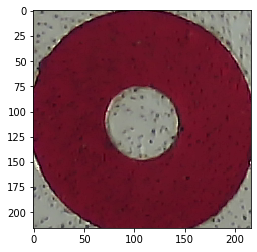

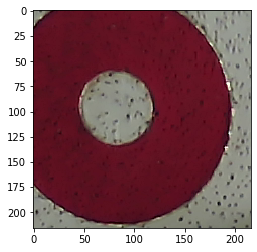

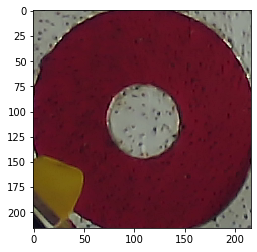

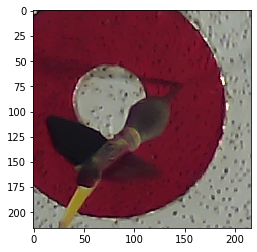

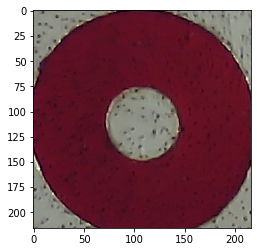

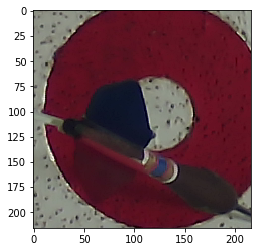

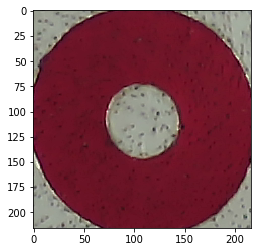

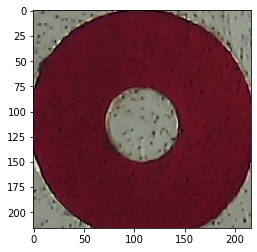

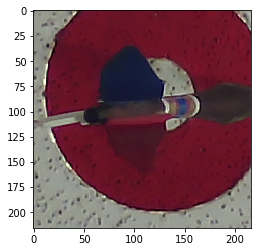

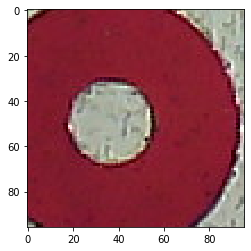

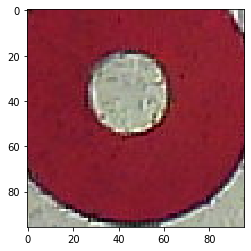

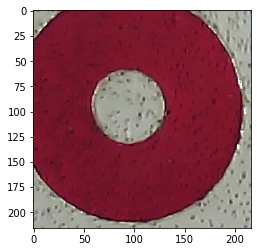

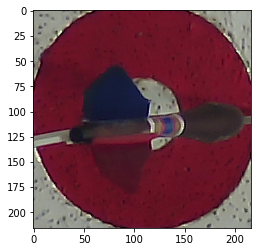

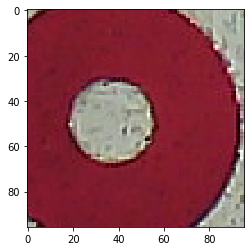

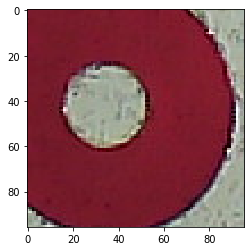

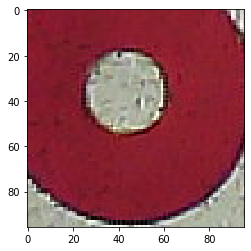

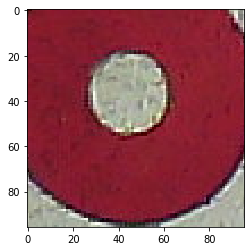

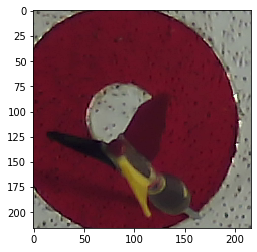

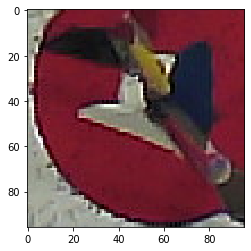

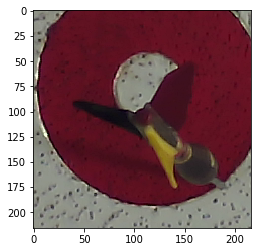

In [7]:
df = df.sort_values('radius')
for img in df.head(20).path.values:
    im = cv2.imread(img)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.show()

Perhaps filtering on radial distance is a simple way to group the data for easier labeling.

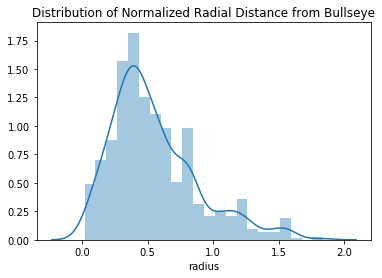

In [8]:
#plt.hist(df.radius.values, bins=30)
ax = sns.distplot(df.radius)
plt.title('Distribution of Normalized Radial Distance from Bullseye')
plt.show()

Above, we see that darts concentrate around a normalized radial distance of 0.3 units from the bullseye. By comparison, the histogram for the angular offset from the horizon is less peaked, though showing a bias indicating darts falling under the bullseye.

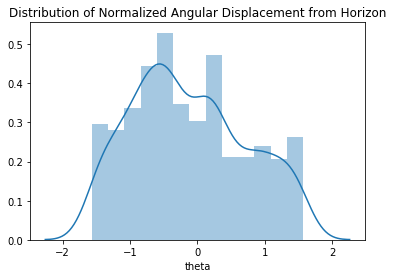

In [9]:
ax = sns.distplot(df.theta)
plt.title('Distribution of Normalized Angular Displacement from Horizon')
plt.show()

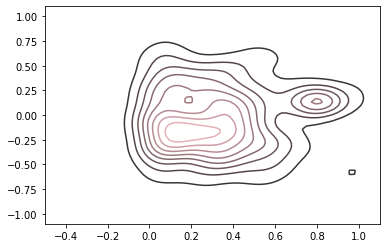

In [10]:
# https://python-graph-gallery.com/1136-2/
p_lst = [(tup[1:3]) for tup in point_lst]
radial_lst = [tuple(tup[1] * np.array((np.cos(tup[0]), np.sin(tup[0])))) for tup in p_lst]
x, y = list(zip(*radial_lst))
density_plot = sns.kdeplot(list(x), list(y), color='pink')
plt.axis([-0.5, 1.1, -1.1, 1.1])
density_plot

In [11]:
n = 10    # Update the Estimated Density after every 10 new images
chunk_lst = [p_lst[i:i + n] for i in range(0, len(p_lst), n)]  # Break the list into chunks of size n

In [12]:
for idx in range(1, len(chunk_lst)):
    x, y = list(zip(*[x for v in chunk_lst[:idx] for x in v]))  # Add 10 new datapoints
    # Compute the new density plot
    density_plot = sns.kdeplot(list(x), list(y), color='pink')
    density_plot.axis('off')
    fig = density_plot.get_figure()
    # Save as a high resolution image for a video
    fig.savefig(ROOT_DIR + '/densities/density_{}.png'.format(str(idx).zfill(4)), transparent=True, format='png', dpi=1200)
    fig.clf()

<Figure size 432x288 with 0 Axes>

Some FFMPEG commands with the transparent overalys to generate an interesting overlay

## Using Simple Features

Tune hog params for speed, simple feature descriptors expressive enough for the dataset

In [13]:
sample_img = 'crops/1576084036758_-0.06_0.37_327_267_216.png'

# Loading a sample Image
im = cv2.imread(sample_img)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [14]:
# Computing the Histogram of Oriented Gradients
# Simple feature description for images
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
im = cv2.resize(im, (50, 50)) 
fd, hog_image = hog(im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True) 


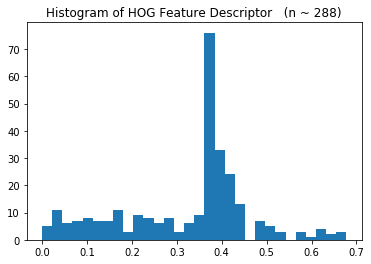

In [15]:
plt.hist(fd, bins=30)
plt.title('Histogram of HOG Feature Descriptor   (n ~ {})'.format(fd.shape[0]))
plt.show()

Used histograms of feature descriptors while exploring HOG parameters w/ a preference for dense distributions across the range.

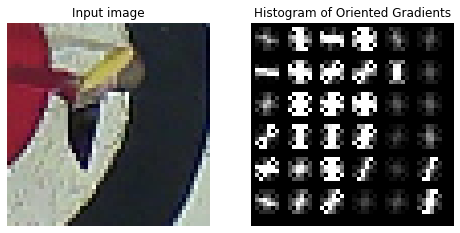

In [16]:
# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(im, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Used plots to qualitatively inspect for visually discernable patterns in HOG feature descriptors.

### Features to Score Dart Blob
 * geometric (normalized radial distance from bullseye)
 * image-content (HOG feature descriptor) 

In [17]:
def cropFeature(im, dist):
    im = cv2.resize(im, (50, 50))
    fd, hog_image = hog(im, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True) 
    return np.concatenate((fd, np.expand_dims(dist, axis=0)))

In [18]:
dp_lst = []
for img in crop_imgs:
    *_, dr, fl = img.split('/')
    try:
        _, _, dist, _, _, _ = get_data(img)
        im = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        dp_lst.append((dr, cropFeature(im, dist)))
    except IndexError:
        pass

## Use Labeled Data to Train ML Algorithm 

In [19]:
y, X = zip(*dp_lst)
X = np.stack(X)
y = np.array(y)

In [20]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.01)

In [21]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
def img_eval(img_path):
    im = cv2.imread(img_path)
    _, _, dist, _, _, _ = get_data(img_path)
    ft_vec = cropFeature(im, dist)
    return clf.predict(np.expand_dims(ft_vec, axis=0))[0]

In [23]:
img_eval(sample_img)

'4'

## Persist the Model for Inference

In [24]:
from joblib import dump, load
dump(clf, open('dart.dat', 'wb'))
clf = load('dart.dat')